In [20]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
%load_ext autoreload
InteractiveShell.ast_node_interactivity = "all"
import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import pandas as pd
import numpy as np
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load Data

In [22]:
# experiment specific
result_base_dir = "frame0_1830_mixAsRef_peptbatchssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.0_threshold_missabthres0.5_convergence_NoIntercept_mix_mzBinDigits2_imPeakWidth4_deltaMobilityThres200"

In [23]:
# edit experiment specific data path and config
import json

result_parent_dir = "/cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/"

result_dir = os.path.join(result_parent_dir, result_base_dir)
with open(os.path.join(result_dir, "param.json"), mode="r", encoding="utf-8") as file:
    config = json.load(file)

maxquant_file_exp = config["MQ_exp_path"]
maxquant_file_ref = os.path.join(result_dir, "maxquant_result_ref.pkl")

In [24]:
maxquant_offline_path = "/cmnfs/proj/ORIGINS/data/brain/txt_3x13Brainregions_MBR_LFQ_iBAQ/evidence_freshfrozen_modseq_charge_1_FilteredByClosestRT_transfer_RT_pred_filtered_withIso_expRTrange.pkl"
maxquant_offline = pd.read_pickle(maxquant_offline_path)

In [25]:
maxquant_result_dict = pd.read_pickle(filepath_or_buffer=maxquant_file_ref)
maxquant_result_exp = pd.read_csv(maxquant_file_exp, sep="\t", low_memory=False)
ms1scans = pd.read_csv(os.path.join(result_dir, "ms1scans.csv"), index_col=0)
mobility_values_df = pd.read_csv(
    os.path.join(result_dir, "mobility_values.csv"), index_col=0
)
pept_sum_df = pd.read_csv(os.path.join(result_dir, "pept_act_sum.csv"), index_col=0)

# Peptide with non zero activation 

### IM_RT slice for peptides

In [2]:
# add up pept sum
import sparse

for batch_num in range(10):
    act_3d = sparse.load_npz(
        os.path.join(
            result_dir, f"output_im_rt_pept_act_coo_batch{batch_num}_peptbatch0.npz"
        )
    )
    logging.info("NNZ size of batch %s act_3d %s", batch_num, act_3d.nnz)
    pept_act_sum = act_3d.sum(axis=(0, 1))
    if batch_num == 0:
        pept_act_sum_all = pept_act_sum
    else:
        pept_act_sum_all += pept_act_sum
    del act_3d, pept_act_sum

NameError: name 'os' is not defined

2024-05-22 16:15:09,497 - utils.plot - INFO - Dictionary entry       Modified sequence  Charge      1/K0  RT_search_left  RT_search_right  \
23609        _HLPPLVGR_       2  0.872804        5.125687         6.925687   

       RT_search_center  Retention time  
23609          6.025687          7.1835  
2024-05-22 16:15:09,506 - utils.plot - INFO - Experiment result:       Modified sequence  Charge  Calibrated retention time start  \
14593        _HLPPLVGR_       2                           5.9141   

       Calibrated retention time finish      1/K0  1/K0 length  
14593                            6.3248  0.874197     0.022681  , bounding box available: [5.9141, 6.3248, 0.4106999999999994, 0.8628561175598782, 0.8855373125363558, 0.0226811949764776]
2024-05-22 16:15:09,511 - postprocessing.ims_3d - DEBUG - No reference RT range given, using dictionary entries: 6.025686910151676, (5.125686910151676, 6.9256869101516765).
2024-05-22 16:15:09,514 - postprocessing.ims_3d - DEBUG - No referenc

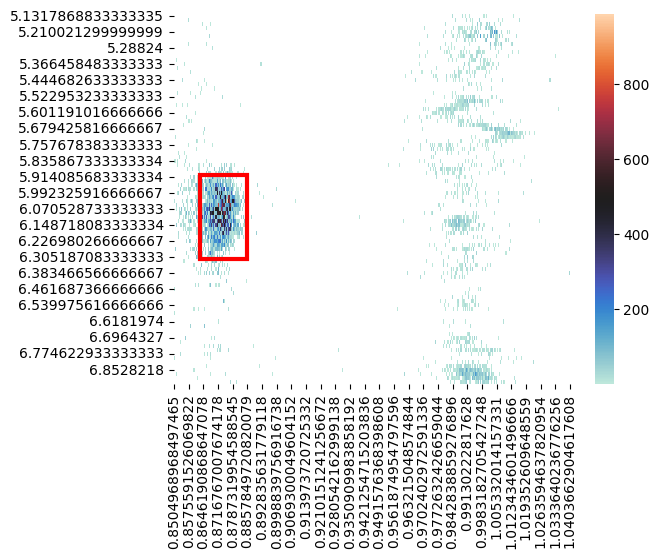

In [ ]:
%autoreload 2
from utils.plot import plot_pept_im_rt_heatmap
import seaborn as sns
#sns.color_palette("icefire", as_cmap=True)
plot_pept_im_rt_heatmap(
    pept_mz_rank=143,
    act_3d=pept_act_batch0,
    maxquant_result_dict=maxquant_result_dict,
    maxquant_result_exp=maxquant_result_exp,
    mobility_values_df=mobility_values_df,
    ms1scans=ms1scans,
    plot_range="nonzero",
    #rt_range=(4.8, 5.2), 
    #im_range = (0.86, 0.9),
    pept_batch_idx=0,
    pept_batch_size=50000
)

In [ ]:
%autoreload 2
from peak_detection_2d.utils import prepare_2d_act_and_bbox, plot_data_points

dp_dict = prepare_2d_act_and_bbox(
    pept_mz_rank=410,
    act_3d=pept_act_batch0,
    maxquant_result_dict=maxquant_result_dict,
    maxquant_result_exp=maxquant_result_exp,
    mobility_values_df=mobility_values_df,
    ms1scans=ms1scans,
)
# plot_data_points(dp_dict, zoom_in=False)
# plt.show()
# plot_data_points(dp_dict, zoom_in=True)
# plt.show()

2024-05-22 16:10:53,174 - peak_detection_2d.utils - INFO - Prepare data for peptide mz rank 410
2024-05-22 16:10:53,178 - postprocessing.ims_3d - DEBUG - No reference RT range given, using dictionary entries: 12.723090958145235, (11.823090958145235, 13.623090958145236).
2024-05-22 16:10:53,180 - postprocessing.ims_3d - DEBUG - No reference IM range given, using dictionary entries: 0.8681481837889383, (0.8281481837889383, 0.9081481837889384).
2024-05-22 16:10:53,181 - peak_detection_2d.utils - INFO - RT and IM range: [901, 994], [0, 116]


Sanity check for data annotation

In [ ]:
data_points = []
for i in range(1, 500):
    dp_dict = prepare_2d_act_and_bbox(
        pept_mz_rank=i,
        act_3d=pept_act_batch0,
        maxquant_result_dict=maxquant_result_dict,
        maxquant_result_exp=maxquant_result_exp,
        mobility_values_df=mobility_values_df,
        ms1scans=ms1scans,
    )
    if dp_dict is not None:
        data_points.append(dp_dict)

2024-05-21 13:54:58,718 - peak_detection_2d.utils - INFO - Prepare data for peptide mz rank 143
2024-05-21 13:54:58,720 - postprocessing.ims_3d - DEBUG - No reference RT range given, using dictionary entries: 6.025686910151676, (5.125686910151676, 6.9256869101516765).
2024-05-21 13:54:58,723 - postprocessing.ims_3d - DEBUG - No reference IM range given, using dictionary entries: 0.872684741974912, (0.8326847419749119, 0.912684741974912).
2024-05-21 13:54:58,723 - peak_detection_2d.utils - INFO - RT and IM range: [559, 652], [0, 125]
2024-05-21 13:54:59,673 - peak_detection_2d.utils - INFO - Prepare data for peptide mz rank 165
2024-05-21 13:54:59,675 - postprocessing.ims_3d - DEBUG - No reference RT range given, using dictionary entries: 5.097637571770915, (4.1976375717709145, 5.997637571770915).
2024-05-21 13:54:59,676 - postprocessing.ims_3d - DEBUG - No reference IM range given, using dictionary entries: 0.8711726624148141, (0.831172662414814, 0.9111726624148141).
2024-05-21 13:54:5

2024-05-21 13:55:16,903 - utils.plot - INFO - Dictionary entry       Modified sequence  Charge      1/K0  RT_search_left  RT_search_right  \
23609        _HLPPLVGR_       2  0.872804        5.125687         6.925687   

       RT_search_center  Retention time  
23609          6.025687          7.1835  
2024-05-21 13:55:16,911 - utils.plot - INFO - Experiment result:       Modified sequence  Charge  Calibrated retention time start  \
14593        _HLPPLVGR_       2                           5.9141   

       Calibrated retention time finish      1/K0  1/K0 length  
14593                            6.3248  0.874197     0.022681  , bounding box available: [5.9141, 6.3248, 0.4106999999999994, 0.8628561175598782, 0.8855373125363558, 0.0226811949764776]
2024-05-21 13:55:16,916 - postprocessing.ims_3d - DEBUG - No reference RT range given, using dictionary entries: 6.025686910151676, (5.125686910151676, 6.9256869101516765).
2024-05-21 13:55:16,918 - postprocessing.ims_3d - DEBUG - No referenc

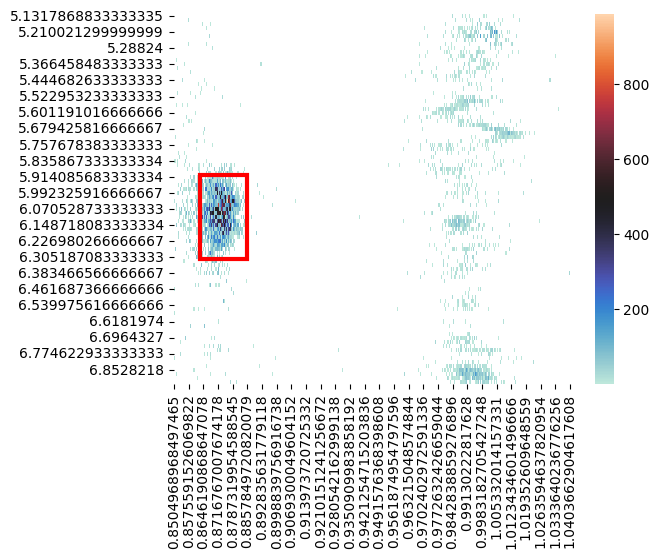

2024-05-21 13:55:18,505 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f5421e3e260>


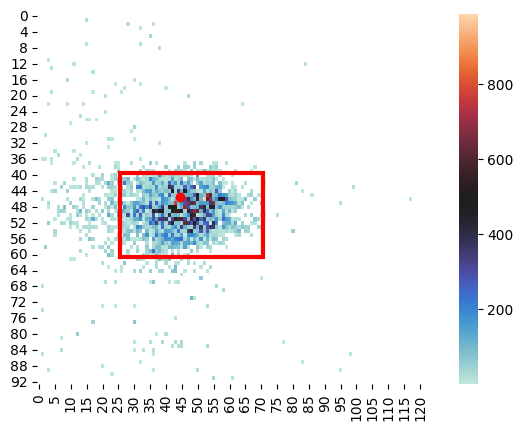

2024-05-21 13:55:18,899 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f5128102ef0>


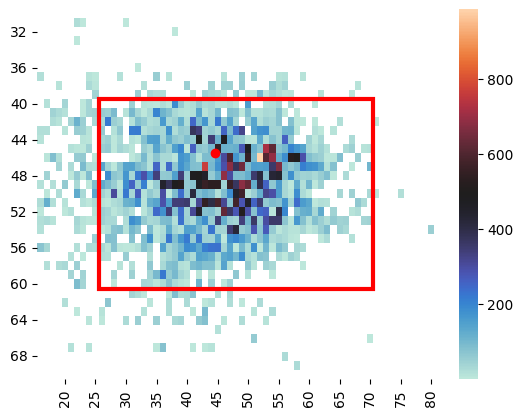

In [ ]:
%autoreload 2
from peak_detection_2d.utils import plot_data_points
import matplotlib.pyplot as plt
from utils.plot import plot_pept_im_rt_heatmap
idx = 0
#data_points[idx]
#plt.subplot(1, 2, 1)
plot_pept_im_rt_heatmap(
    pept_mz_rank=143,
    act_3d=pept_act_batch0,
    maxquant_result_dict=maxquant_result_dict,
    maxquant_result_exp=maxquant_result_exp,
    mobility_values_df=mobility_values_df,
    ms1scans=ms1scans,
    plot_range="nonzero",
    #rt_range=(4.8, 5.2), 
    #im_range = (0.86, 0.9),
)
plt.show()
plot_data_points(data_points[idx], zoom_in=False)
plt.show()
plot_data_points(data_points[idx], zoom_in=True)

{'bbox': array([106,  39, 158,  45]),
 'data': array([[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [61.68100453,         nan,         nan, ...,         nan,
                 nan,         nan]]),
 'hint_idx': array([ 44, 161]),
 'pept_mz_rank': 50163}

2024-05-21 15:18:30,190 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f512b03baf0>


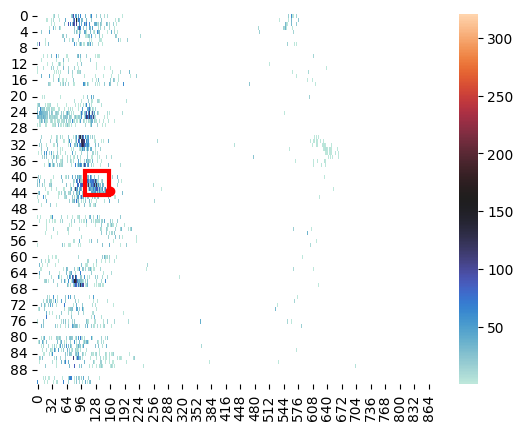

2024-05-21 15:18:30,715 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f512b72ec50>


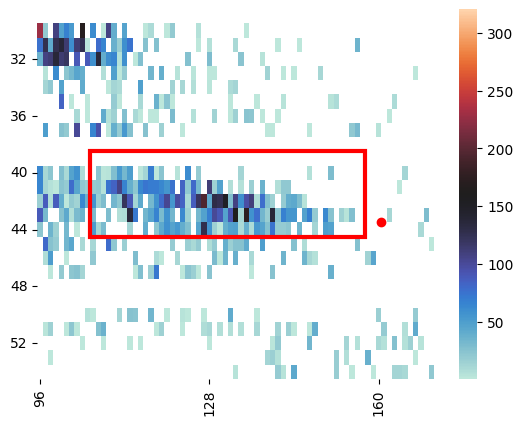

In [ ]:
%autoreload 2
from peak_detection_2d.utils import plot_data_points
import matplotlib.pyplot as plt
idx = 2
data_points[idx]
#plt.subplot(1, 2, 1)
plot_data_points(data_points[idx], zoom_in=False)
plt.show()
plot_data_points(data_points[idx], zoom_in=True)
plt.show()

In [ ]:
from postprocessing.ims_3d import (
    get_ref_rt_im_range,
    slice_pept_act,
    prepare_slice_pept_act_df,
    detect_2d_peaks_apex,
    get_highest_score_peak_apex,
)

rt_idx_range, im_idx_range, reference_entry = get_ref_rt_im_range(
    pept_mz_rank=23630,
    maxquant_result_dict=maxquant_result_dict,
    mobility_values_df=mobility_values_df,
    ms1scans=ms1scans,
)
slice_pept_act_sparse, rt_idx_range, im_idx_range = slice_pept_act(
    pept_act_sparse=pept_act_batch0[:, :, 23630],
    plot_range="custom",
    rt_idx_range=rt_idx_range,
    im_idx_range=im_idx_range,
)
slice_pept_act_df = prepare_slice_pept_act_df(
    slice_pept_act_sparse, rt_idx_range, im_idx_range, mobility_values_df, ms1scans
)
apex_mat, apex_indices = detect_2d_peaks_apex(slice_pept_act_df, filter_size=(5, 75))
rt_apex, im_apex = get_highest_score_peak_apex(
    peak_apex_list=apex_indices, reference_entry=[2.51, 0.883266]
)
rt_apex, im_apex

2024-04-11 15:42:01,275 - postprocessing.ims_3d - DEBUG - No reference rt range given, using dictionary entries.
2024-04-11 15:42:01,280 - postprocessing.ims_3d - DEBUG - No reference im range given, using dictionary entries.


2024-04-11 15:42:02,224 - postprocessing.ims_3d - INFO - Number of detected apex with size (5, 75): 17


(2.8439742333333333, 0.8827625515867574)

In [ ]:
from postprocessing.ims_3d import get_peak_rt_im_range

rt_indices, im_indices = get_peak_rt_im_range(
    peak_apex=(rt_apex, im_apex), pept_ref_slice=slice_pept_act_df
)
rt_indices, im_indices

((2.6680269666666665, 2.9417981666666666),
 (0.8757085816456783, 0.8888069670194227))

In [ ]:
rt_filtered_idx, im_filtered_idx = get_ref_rt_im_range(
    pept_mz_rank=23630,
    maxquant_result_dict=maxquant_result_dict,
    mobility_values_df=mobility_values_df,
    ms1scans=ms1scans,
    ref_rt_range=rt_indices,
    ref_im_range=im_indices,
)
filter_peak_sparse, _, _ = slice_pept_act(
    pept_act_sparse=pept_act_batch0[:, :, 23630],
    plot_range="custom",
    rt_idx_range=rt_filtered_idx,
    im_idx_range=im_filtered_idx,
)

In [ ]:
filter_peak_sparse.sum(axis=(0, 1))

2024-04-11 13:35:16,325 - numba.core.byteflow - DEBUG - bytecode dump:
>          0	NOP(arg=None, lineno=1584)
           2	BUILD_LIST(arg=0, lineno=1586)
           4	STORE_FAST(arg=1, lineno=1586)
           6	BUILD_LIST(arg=0, lineno=1587)
           8	STORE_FAST(arg=2, lineno=1587)
          10	LOAD_GLOBAL(arg=0, lineno=1589)
          12	LOAD_FAST(arg=0, lineno=1589)
          14	CALL_FUNCTION(arg=1, lineno=1589)
          16	LOAD_CONST(arg=1, lineno=1589)
          18	COMPARE_OP(arg=2, lineno=1589)
          20	POP_JUMP_IF_FALSE(arg=28, lineno=1589)
          22	LOAD_GLOBAL(arg=1, lineno=1591)
          24	LOAD_ATTR(arg=2, lineno=1591)
          26	LOAD_FAST(arg=1, lineno=1591)
          28	LOAD_FAST(arg=0, lineno=1591)
          30	LOAD_ATTR(arg=3, lineno=1591)
          32	LOAD_CONST(arg=2, lineno=1591)
          34	CALL_FUNCTION_KW(arg=2, lineno=1591)
          36	LOAD_GLOBAL(arg=1, lineno=1592)
          38	LOAD_ATTR(arg=2, lineno=1592)
          40	LOAD_FAST(arg=2, lineno=15

2024-04-11 13:35:16,373 - numba.core.byteflow - DEBUG - dispatch pc=52, inst=RETURN_VALUE(arg=None, lineno=1590)
2024-04-11 13:35:16,374 - numba.core.byteflow - DEBUG - stack ['$50build_tuple.14']
2024-04-11 13:35:16,375 - numba.core.byteflow - DEBUG - end state. edges=[]
2024-04-11 13:35:16,375 - numba.core.byteflow - DEBUG - pending: deque([State(pc_initial=54 nstack_initial=0)])
2024-04-11 13:35:16,376 - numba.core.byteflow - DEBUG - stack: []
2024-04-11 13:35:16,377 - numba.core.byteflow - DEBUG - state.pc_initial: State(pc_initial=54 nstack_initial=0)
2024-04-11 13:35:16,378 - numba.core.byteflow - DEBUG - dispatch pc=54, inst=LOAD_FAST(arg=1, lineno=1595)
2024-04-11 13:35:16,379 - numba.core.byteflow - DEBUG - stack []
2024-04-11 13:35:16,380 - numba.core.byteflow - DEBUG - dispatch pc=56, inst=LOAD_METHOD(arg=4, lineno=1595)
2024-04-11 13:35:16,380 - numba.core.byteflow - DEBUG - stack ['$inv_idx54.0']
2024-04-11 13:35:16,381 - numba.core.byteflow - DEBUG - dispatch pc=58, inst=

42389.65574124241

2024-04-11 16:33:16,319 - utils.plot - INFO - Dictionary entry       Modified sequence  Charge  RT_search_left  RT_search_right  \
40009       _YPMEHGIVK_       2        3.683338         5.483338   

       RT_search_center  
40009          4.583338  
2024-04-11 16:33:16,326 - utils.plot - INFO - Experiment result:       Modified sequence  Charge  Calibrated retention time start  \
37032       _YPMEHGIVK_       2                           4.8776   

       Calibrated retention time finish  Retention time  Ion mobility index  \
37032                            5.0926          4.9753                 897   

              m/z     1/K0  1/K0 length  Score  Intensity  
37032  537.276052  0.86966     0.040809  125.5   286120.0  
2024-04-11 16:33:16,330 - postprocessing.ims_3d - DEBUG - No reference rt range given, using dictionary entries.
2024-04-11 16:33:16,332 - postprocessing.ims_3d - DEBUG - No reference im range given, using dictionary entries.
2024-04-11 16:33:17,260 - matplotlib.colo

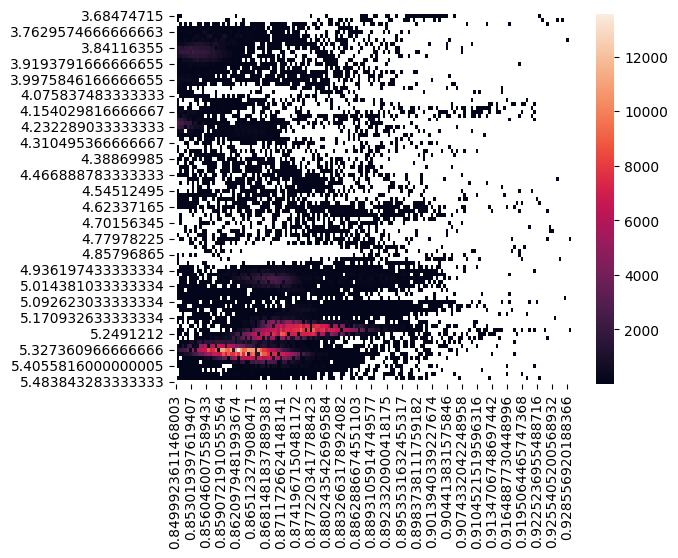

In [ ]:
%autoreload 2
from postprocessing.ims_3d import get_peak_sum_from_pept_slice
from utils.plot import plot_pept_im_rt_heatmap
mz_rank = 17296
plot_pept_im_rt_heatmap(
    pept_mz_rank=mz_rank,
    act_3d=pept_act_batch0,
    maxquant_result_dict=maxquant_result_dict,
    maxquant_result_exp=maxquant_result_exp,
    mobility_values_df=mobility_values_df,
    ms1scans=ms1scans,
    plot_range="custom",
    #rt_range = (14.0, 14.9), 
    #im_range = (0.90, 0.92),
)
peak_sum = get_peak_sum_from_pept_slice(
    pept_mz_rank=mz_rank,
    pept_act_sparse=pept_act_batch0[:, :, mz_rank],
    maxquant_result_dict=maxquant_result_dict,
    ms1scans=ms1scans,
    mobility_values_df=mobility_values_df,
    filter_size=(10,50),
)

<Axes: >

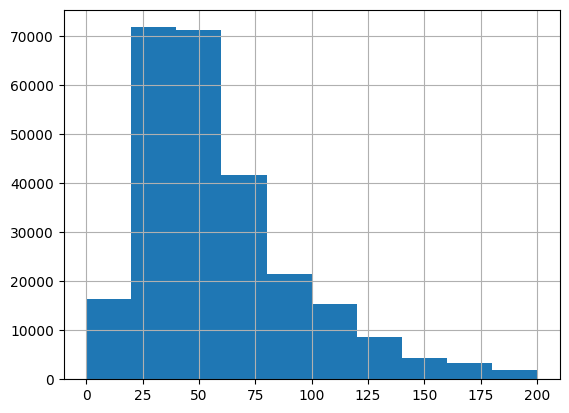

In [ ]:
maxquant_result_dict["Retention length"].hist(range=(0, 200))

In [ ]:
maxquant_result_dict.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Gene names',
       'Protein names', 'Type', 'Raw file', 'Fraction', 'Experiment',
       'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/

In [ ]:
from utils.plot import slice_pept_act

pept_ref_slice = slice_pept_act(
    pept_mz_rank=23630,
    act_3d=pept_act_batch0,
    maxquant_result_dict=maxquant_result_dict,
    # maxquant_result_exp=maxquant_result_exp,
    mobility_values_df=mobility_values_df,
    ms1scans=ms1scans,
    plot_range="reference",
    custom_range=([2.6, 3.0], [0.85, 0.93]),
)

In [ ]:
pept_ref_slice_denoise = pept_ref_slice.where(pept_ref_slice < 10, 0)

(array([307., 518., 251., 111.,  62.,  77.,  98.,  86.,  74.,  96.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

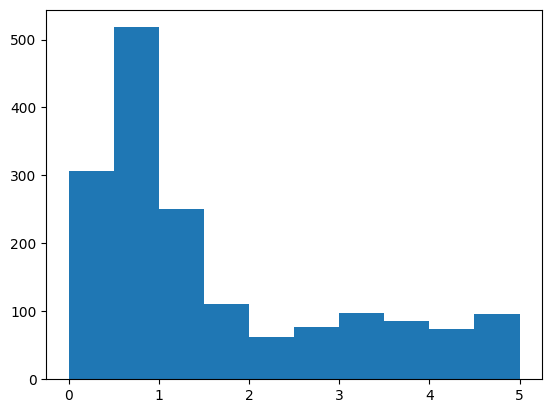

In [ ]:
plt.hist(pept_ref_slice.values.flatten(), range=(0, 5))

In [ ]:
pept_ref_melt = pd.melt(
    pept_ref_slice.reset_index(),
    id_vars=["Time_minute"],
    var_name=["mobility_values"],
    value_name="intensity",
)
pept_ref_melt = pept_ref_melt.dropna(subset=["intensity"])

### Raw data

In [ ]:
import alphatims.bruker

config["d_path"]
data = alphatims.bruker.TimsTOF(config["d_path"])

2024-04-05 10:24:11,862 - h5py._conv - DEBUG - Creating converter from 7 to 5
2024-04-05 10:24:11,864 - h5py._conv - DEBUG - Creating converter from 5 to 7
2024-04-05 10:24:11,865 - h5py._conv - DEBUG - Creating converter from 7 to 5
2024-04-05 10:24:11,867 - h5py._conv - DEBUG - Creating converter from 5 to 7


'/cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921.d'

2024-04-05 10:24:11,913 - root - INFO - Importing data from /cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921.d
2024-04-05 10:24:11,915 - root - INFO - Using HDF import for /cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921.hdf
2024-04-05 10:24:12,203 - h5py._conv - DEBUG - Creating converter from 3 to 5
2024-04-05 10:24:12,340 - numba.core.byteflow - DEBUG - bytecode dump:
>          0	NOP(arg=None, lineno=2960)
           2	BUILD_LIST(arg=0, lineno=3027)
           4	STORE_FAST(arg=14, lineno=3027)
           6	LOAD_CONST(arg=1, lineno=3028)
           8	STORE_FAST(arg=15, lineno=3028)
          10	LOAD_CONST(arg=1, lineno=3029)
          12	STORE_FAST(arg=16, lineno=3029)
          14	LOAD_CONST(arg=1, lineno=3030)
          16	STORE_FAST(arg=17, lineno=3030)
          18	LOAD_CONST(arg=2, lineno=3031)
          20	STORE_FAST(arg=18, lineno=3031)
          22	LOAD_FAST(arg=8, linen

In [ ]:
import sparse


coords = [[0, 1, 2, 3, 4], [0, 1, 2, 3, 4]]
data = [10, 20, 30, 40, 50]
s = sparse.COO(coords, data, shape=(5, 5))
b = sparse.COO(coords, data, shape=(5, 5))
bs = b + s

2024-04-05 16:05:54,010 - numba.core.byteflow - DEBUG - bytecode dump:
>          0	NOP(arg=None, lineno=52)
           2	LOAD_GLOBAL(arg=0, lineno=69)
           4	LOAD_FAST(arg=0, lineno=69)
           6	CALL_FUNCTION(arg=1, lineno=69)
           8	LOAD_CONST(arg=1, lineno=69)
          10	COMPARE_OP(arg=2, lineno=69)
          12	POP_JUMP_IF_TRUE(arg=14, lineno=69)
          14	LOAD_GLOBAL(arg=0, lineno=69)
          16	LOAD_FAST(arg=1, lineno=69)
          18	CALL_FUNCTION(arg=1, lineno=69)
          20	LOAD_CONST(arg=1, lineno=69)
          22	COMPARE_OP(arg=2, lineno=69)
          24	POP_JUMP_IF_FALSE(arg=30, lineno=69)
>         26	LOAD_GLOBAL(arg=1, lineno=70)
          28	LOAD_ATTR(arg=2, lineno=70)
          30	LOAD_CONST(arg=1, lineno=70)
          32	LOAD_GLOBAL(arg=1, lineno=70)
          34	LOAD_ATTR(arg=3, lineno=70)
          36	LOAD_CONST(arg=2, lineno=70)
          38	CALL_FUNCTION_KW(arg=2, lineno=70)
          40	LOAD_GLOBAL(arg=1, lineno=70)
          42	LOAD_ATTR(

In [ ]:
sparse.asnumpy(bs)

array([[ 20,   0,   0,   0,   0],
       [  0,  40,   0,   0,   0],
       [  0,   0,  60,   0,   0],
       [  0,   0,   0,  80,   0],
       [  0,   0,   0,   0, 100]])

In [ ]:
data_plot = data[
    {
        "frame_indices": ms1scans.loc[x_range[0] : x_range[1], "Id"],
        "mz_values": slice(773.3, 773.4),
        # "mobility_values": slice(0.97, 1.01),
    }
]
# import alphatims.plotting as ap

raw_data_slice = pd.pivot_table(
    data=data_plot,
    index="rt_values_min",
    columns="mobility_values",
    values="intensity_values",
    aggfunc="sum",
)
# ap.heatmap(df=data_plot, x_axis_label="mobility", y_axis_label="rt")
sns.heatmap(raw_data_slice)

NameError: name 'data' is not defined

## Correlation

In [ ]:
# if "predicted_RT" not in maxquant_result_dict.columns:
#     maxquant_result_dict["predicted_RT"] = maxquant_result_dict["RT_search_center"]
# maxqunat_result_dict_sortmz = maxquant_result_dict.sort_values("mz_rank")

In [ ]:
# try:
#     pept_act_sum_df = pd.read_csv(
#         os.path.join(config["result_dir"], "pept_act_sum.csv"), index_col=0
#     )
# except FileNotFoundError:
#     pept_act_sum_array = sparse.asnumpy(pept_act_sum_all)
#     pept_act_sum_df = pd.DataFrame(
#         pept_act_sum_array[:],
#         columns=["pept_act_sum"],
#         index=np.arange(pept_act_sum_array.shape[0]),
#     )
#     pept_act_sum_df.to_csv(os.path.join(config["result_dir"], "pept_act_sum.csv"))

In [27]:
pept_sum_df["pept_mz_rank"] = pept_sum_df.index

2024-06-13 09:13:28,576 - result_analysis.result_analysis - INFO - Reference shape: (259551, 94)


2024-06-13 09:13:28,963 - result_analysis.result_analysis - DEBUG - Reference shape after merging activation sum: (259551, 96)
2024-06-13 09:13:28,986 - result_analysis.result_analysis - DEBUG - sum cols: ['pept_act_sum', 'pept_mz_rank']
2024-06-13 09:13:29,429 - result_analysis.result_analysis - DEBUG - Reference non zero shape: (259488, 96)
2024-06-13 09:13:29,526 - result_analysis.compare_maxquant - INFO - Experiment data: removing 2297 entries with aggregation over PCM, 35151 entries left.
2024-06-13 09:13:29,678 - result_analysis.compare_maxquant - DEBUG - Experiment file has 35151 entries.
2024-06-13 09:13:29,680 - result_analysis.compare_maxquant - DEBUG - Merged file has 35151 entries.
2024-06-13 09:13:30,221 - result_analysis.compare_maxquant - INFO - RT overlap counts: full_overlap       33214
partial_overlap     1273
no_entry_in_ref      664
Name: RT_overlap, dtype: int64
2024-06-13 09:13:30,235 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_

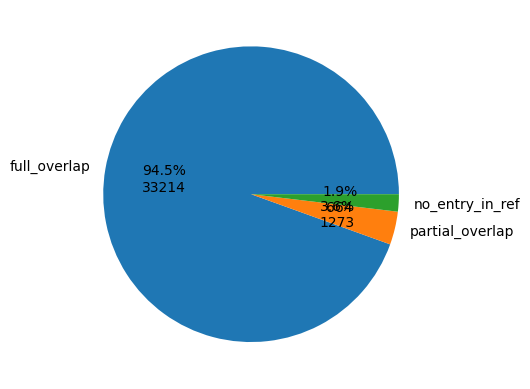

2024-06-13 09:13:31,395 - result_analysis.result_analysis - INFO - No filter_by_rt_overlap is specified, use all entries for plotting.
2024-06-13 09:13:31,396 - result_analysis.result_analysis - INFO - Ref exp inner join shape: (35151, 21)


In [29]:
%autoreload 2
from result_analysis.result_analysis import SBSResult
sbs_ims_result = SBSResult(
    maxquant_ref_df=maxquant_result_dict,
    maxquant_exp_df=maxquant_result_exp,
    sum_raw=pept_sum_df,
    #sum_gaussian = auc_raw,
    ims=True,
)
sbs_ims_result.compare_with_maxquant_exp_int(
    filter_by_rt_overlap=None, handle_mul_exp_pcm="agg", save_dir=None)


In [37]:
sbs_ims_result.plot_intensity_corr(
    inf_col="pept_act_sum",
    interactive=False,
    # save_dir=None,
    contour=False,
    log_x=True,
    log_y=True,
    hover_data=["Modified sequence", "Charge", "mz_rank"],
    # color=SBS_ss1FDR_PSM.ref_exp_df_inner["Length"],
    save_dir=config["report_dir"],
)

Data:  Intensity_log pept_act_sum_log , slope =  0.873 , intercept =  0.263 , PearsonR =  0.928 , SpearmanR =  0.914


2024-06-13 09:28:27,028 - result_analysis.result_analysis - DEBUG - Experiment columns: Index(['Modified sequence', 'Charge', 'Calibrated retention time start',
       'Calibrated retention time finish', 'Calibrated retention time',
       'Retention time', 'Intensity', 'id', 'Mass', 'm/z', 'Length',
       'Reverse'],
      dtype='object')
2024-06-13 09:28:27,086 - result_analysis.result_analysis - INFO - Unique PCM TD in experiment: (35151, 7)
/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py:389: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2024-06-13 09:28:27,251 - result_analysis.result_analysis - INFO - Unique PCM TD in non zero activations: (259488, 97)


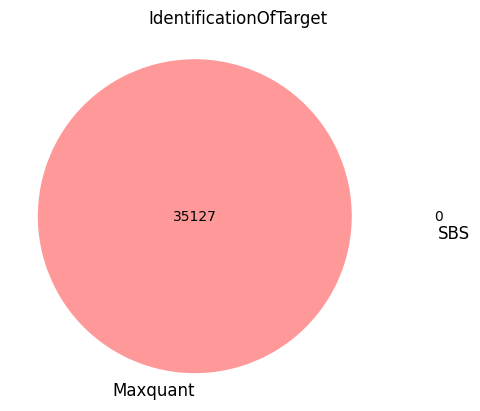

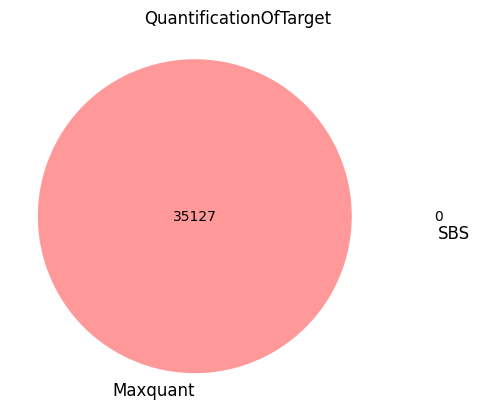

In [39]:
sbs_ims_result.plot_overlap_with_MQ()

2024-04-03 14:22:07,287 - utils.plot - DEBUG - RT search range: [12.949009017446059, 14.74900901744606]
2024-04-03 14:22:07,288 - utils.plot - DEBUG - mod_seq: _SLYQSAGVAPESFEYIEAHGTGTK_, charge: 3
2024-04-03 14:22:07,293 - utils.plot - DEBUG - RT exp range [array([13.554]), array([13.711])]


,Time_minute,raw,Scan index
0,12.964942,173.522305,NaN
1,12.984647,0.000000,NaN
2,13.004381,11.773809,NaN
3,13.023998,0.000000,NaN
4,13.043576,77.589440,NaN
...,...,...,...
86,14.656036,123.473891,NaN
87,14.675634,0.000000,NaN
88,14.695496,0.000000,NaN
89,14.715132,0.000000,NaN


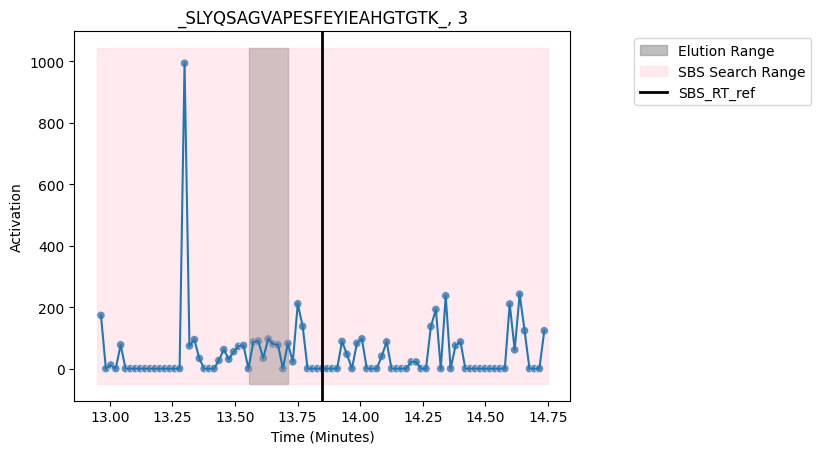

In [ ]:
from utils.plot import plot_activation

activation = activation.fillna(0)
pept_mzrank = 178243
plot_activation(
    maxquant_ref_row=maxquant_result_dict.loc[
        maxquant_result_dict["mz_rank"] == pept_mzrank, :
    ],
    maxquant_exp_df=maxquant_result_exp,
    precursor_activations=[activation.loc[:, pept_mzrank]],
    activation_labels=["raw"],
    ms1scan_no_array=ms1scans.loc[activation.index.values],
    ms1scan_time_col="Time_minute",
)

In [ ]:
# Make result directory
report_dir = os.path.join(result_dir, "report")
if not os.path.exists(report_dir):
    os.makedirs(report_dir)
    os.makedirs(os.path.join(report_dir, "activation"))

# Statistics

## Determine image size
With RT search range 1.8 minutes (0.9 minutes * 2), and IM search range of 0.08 (delta IM = 0.04), calculate the maximum RT range and IM range in terms of index number for padding input data

In [ ]:
pd.cut(mobility_values_df["mobility_values"], bins=5).value_counts()

(1.224, 1.317]    189
(1.037, 1.13]     188
(1.13, 1.224]     188
(0.85, 0.943]     186
(0.943, 1.037]    186
Name: mobility_values, dtype: int64

In [ ]:
pd.cut(ms1scans["Time_minute"], bins=20).value_counts()

(-0.03, 1.499]      374
(28.485, 29.985]     79
(2.998, 4.498]       77
(19.49, 20.989]      77
(26.986, 28.485]     77
(7.496, 8.995]       77
(8.995, 10.495]      77
(25.487, 26.986]     77
(13.493, 14.992]     77
(22.488, 23.988]     77
(4.498, 5.997]       77
(23.988, 25.487]     76
(20.989, 22.488]     76
(16.492, 17.991]     76
(17.991, 19.49]      76
(1.499, 2.998]       76
(11.994, 13.493]     76
(10.495, 11.994]     76
(5.997, 7.496]       76
(14.992, 16.492]     76
Name: Time_minute, dtype: int64

Set image size 180*180

In [ ]:
moodleMaxquant_result_dict.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'Experiment', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Resolution', 'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Match time difference',
       'Match m/z difference', 'Match q-value', 'Match score',
       'Number of data points', 'Number of scans', 'Number of isotopic peaks',
       'PIF', 'Fraction of total spectrum', 'Base 

# SBS and MQ Elution(RT) comparison

In [ ]:
from result_analysis.result_analysis import FindStartAndEndScan
import result_analysis.result_analysis

reload(result_analysis.result_analysis)

ElutionScan = FindStartAndEndScan(activation=activation)
MS1Scans_NoArray["Scan Index"] = MS1Scans_NoArray.index
MQElutionScan = Maxquant_result_dict[
    [
        "id",
        "Modified sequence",
        "Charge",
        "Retention length",
        "Calibrated retention time start",
        "Calibrated retention time finish",
        "Number of data points",
        "Number of scans",
        "Number of isotopic peaks",
        "Intensity",
        "AUCActivation_Gaussian",
    ]
]
MQElutionScan.sort_values(by="Calibrated retention time start", inplace=True)
MQElutionScan = pd.merge_asof(
    left=MQElutionScan,
    right=MS1Scans_NoArray[["starttime", "Scan Index"]],
    left_on="Calibrated retention time start",
    right_on="starttime",
    direction="nearest",
)
MQElutionScan.sort_values(by="Calibrated retention time finish", inplace=True)
MQElutionScan = pd.merge_asof(
    left=MQElutionScan,
    right=MS1Scans_NoArray[["starttime", "Scan Index"]],
    left_on="Calibrated retention time finish",
    right_on="starttime",
    direction="nearest",
    suffixes=["_start_MQ", "_end_MQ"],
)
MQElutionScan["CountScan_MQ"] = (
    MQElutionScan["Scan Index_end_MQ"] - MQElutionScan["Scan Index_start_MQ"] + 1
)
ElutionScan = pd.merge(left=ElutionScan, right=MQElutionScan)
ElutionScan["MQ_SBS_diff"] = ElutionScan["CountScan_MQ"] - ElutionScan["CountScan_SBS"]
ElutionScan["MQ_SBS_start_diff"] = (
    ElutionScan["Scan Index_start_MQ"] - ElutionScan["Scan Index_start_SBS"]
)
ElutionScan["MQ_SBS_end_diff"] = (
    ElutionScan["Scan Index_end_MQ"] - ElutionScan["Scan Index_end_SBS"]
)

<module 'result_analysis.result_analysis' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py'>

/tmp/ipykernel_27132/522126409.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MQElutionScan.sort_values(by = 'Calibrated retention time start', inplace=True)


Data:  Intensity_log AUCActivation_Gaussian_log , slope =  0.92 , intercept =  -0.315 , PearsonR =  0.813 , SpearmanR =  0.812


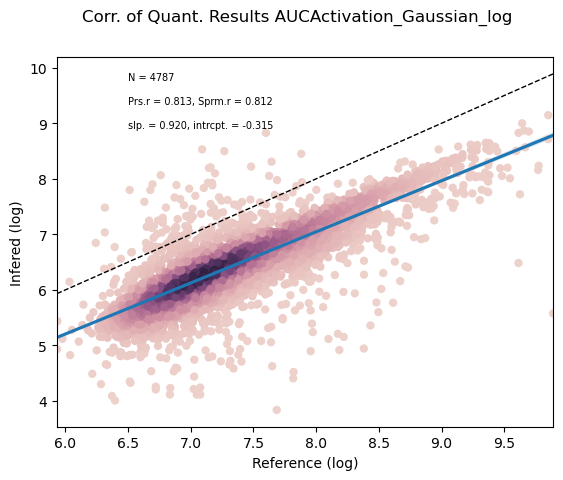

(array([6.09291904, 7.6067549 , 7.27448721, ..., 6.08379386, 7.01468229,
        6.05554934]),
 array([0.09478726, 0.08914836, 0.10194525, ..., 0.14158101, 1.62334872,
        0.29464599]),
 (array([   0,    1,    2, ..., 4945, 4946, 4947]),))

In [ ]:
ElutionScan_filtered = ElutionScan[(abs(ElutionScan["MQ_SBS_start_diff"]) <= 10)]
PlotCorr(
    ElutionScan_filtered["Intensity"],
    ElutionScan_filtered["AUCActivation_Gaussian"],
    interactive=False,
    data=ElutionScan_filtered,
)

In [ ]:
ElutionScan["MQ_SBS_start_diff"].describe()
ElutionScan["MQ_SBS_end_diff"].describe()

count    15131.000000
mean        15.201969
std        158.183104
min      -2032.000000
25%        -18.000000
50%         -1.000000
75%         43.000000
max       2519.000000
Name: MQ_SBS_start_diff, dtype: float64

count    15131.000000
mean         0.041174
std        159.956517
min      -2014.000000
25%        -50.000000
50%          0.000000
75%         12.000000
max       2452.000000
Name: MQ_SBS_end_diff, dtype: float64

count    13564.000000
mean       -17.646859
std         28.656715
min       -154.000000
25%        -41.000000
50%        -13.000000
75%          5.000000
max        241.000000
Name: MQ_SBS_diff, dtype: float64

<Axes: >

Text(0.5, 0, 'Elution Scan Count MQ - Elution Scan Count SBS')

Text(0, 0.5, 'count')

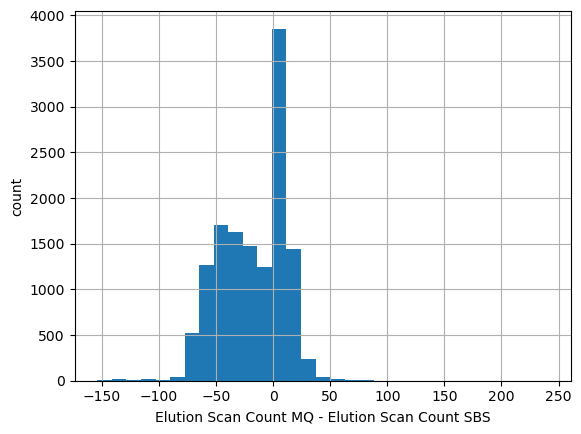

In [ ]:
import matplotlib.pyplot as plt

ElutionScan = ElutionScan.dropna(subset=["Intensity"])
ElutionScan["MQ_SBS_diff"].describe()
ElutionScan["MQ_SBS_diff"].hist(bins=31)
plt.xlabel("Elution Scan Count MQ - Elution Scan Count SBS")
plt.ylabel("count")

# Alphas

<module 'result_analysis.result_analysis' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py'>

Alpha range:  [1.e-05 1.e-04 1.e-03 0.e+00 1.e-02 1.e-01 1.e+00 1.e+01] , replacing all zeros with 1.0000000000000002e-06


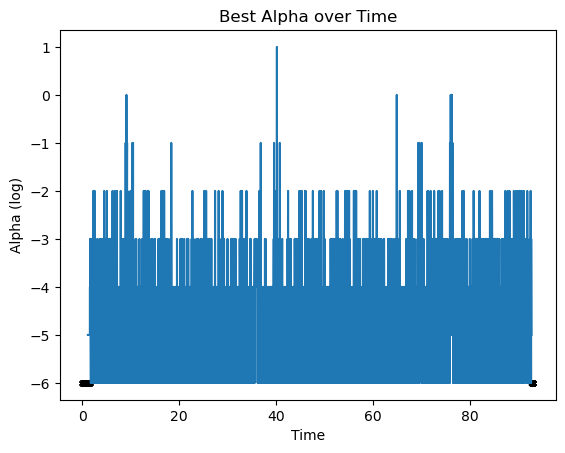

In [ ]:
from result_analysis.result_analysis import plot_alphas_across_scan
import result_analysis.result_analysis

reload(result_analysis.result_analysis)

plot_alphas_across_scan(NonEmptyScans=NonEmptyScans, EmptyScans=emptyScans, x="Time")

# Batch Correlation and Report

In [ ]:
from result_analysis.result_analysis import PlotCorr
import result_analysis.result_analysis
import utils.plot

reload(utils.plot)

reload(result_analysis.result_analysis)

for sum_col in [
    sum_minima.iloc[:, 0],
    sum_minima.iloc[:, 1],
    sum_minima.iloc[:, 2],
    sum_gaussian.iloc[:, 0],
    sum_gaussian.iloc[:, 1],
    sum_gaussian.iloc[:, 2],
    Maxquant_result_dict["SumActivation"],
]:
    print(sum_col.name)
    _, _, _ = PlotCorr(
        Maxquant_result_dict["Intensity"], sum_col, data=None, save_dir=report_dir
    )

<module 'utils.plot' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utils/plot.py'>

<module 'result_analysis.result_analysis' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py'>

SumActivationLocalMinima
Data:  Intensity_log SumActivationLocalMinima_log , slope =  0.969 , intercept =  1.033 , PearsonR =  0.901 , SpearmanR =  0.889
AUCAcitvationLocalMinima
Data:  Intensity_log AUCAcitvationLocalMinima_log , slope =  0.961 , intercept =  -0.515 , PearsonR =  0.902 , SpearmanR =  0.889
TRPZActivationLocalMinima
Data:  Intensity_log TRPZActivationLocalMinima_log , slope =  0.961 , intercept =  -0.515 , PearsonR =  0.902 , SpearmanR =  0.889
SumActivationGaussianKernel
Data:  Intensity_log SumActivationGaussianKernel_log , slope =  0.975 , intercept =  0.92 , PearsonR =  0.906 , SpearmanR =  0.895
AUCAcitvationGaussianKernel
Data:  Intensity_log AUCAcitvationGaussianKernel_log , slope =  0.966 , intercept =  -0.627 , PearsonR =  0.908 , SpearmanR =  0.895
TRPZActivationGaussianKernel
Data:  Intensity_log TRPZActivationGaussianKernel_log , slope =  0.966 , intercept =  -0.627 , PearsonR =  0.908 , SpearmanR =  0.895
SumActivation
Data:  Intensity_log SumActivation_lo

In [ ]:
from result_analysis.result_analysis import GenerateResultReport
NonEmptyScans = GenerateResultReport(emptyScans= emptyScans, 
                                     NonEmptyScans=NonEmptyScans,
                                     intensity_cols=[Maxquant_result_dict['Intensity'],
                                                    Maxquant_result_dict['SumActivation'], 
                                                    sum_gaussiadf_percentage_change["Change"]n.iloc[:, 0],
                                                    sum_gaussian.iloc[:, 1],
                                                    sum_minima.iloc[:, 0],
                                                    sum_minima.iloc[:, 1]
                                                    ],
                                     save_dir=report_dir)

-------------- Intensity -----------------
Non zero intensity in Intensity = 17477
-------------- SumActivation -----------------
Non zero intensity in SumActivation = 19418
-------------- SumActivationGaussianKernel -----------------
Non zero intensity in SumActivationGaussianKernel = 19418
-------------- AUCAcitvationGaussianKernel -----------------
Non zero intensity in AUCAcitvationGaussianKernel = 19418
-------------- SumActivationLocalMinima -----------------
Non zero intensity in SumActivationLocalMinima = 19418
-------------- AUCAcitvationLocalMinima -----------------
Non zero intensity in AUCAcitvationLocalMinima = 19418
--------------Empty Scans-----------------
Emptry Scans time distribution:
count    724.000000
mean      16.376719
std       34.606065
min        0.002775
25%        0.423449
50%        0.847510
75%        1.382445
max       92.998972
Name: Time, dtype: float64
--------------Non Empty Scans-----------------
Non Emptry Scans reconstruction cosine distance distr

### Plot Activation

In [ ]:
from result_analysis.result_analysis import PlotActivation

for idx in Accurate50_idx:
    _ = PlotActivation(
        MaxquantEntry=Maxquant_result_dict.iloc[idx, :],
        PrecursorTimeProfiles=[
            activation[idx, :],
            refit_activation_minima[idx, :],
            refit_activation_gaussian[idx, :],
        ],
        PrecursorTimeProfileLabels=["None", "LocalMinima", "Gaussian"],
        MS1ScansNoArrary=MS1Scans_NoArray,
        save_dir=os.path.join(report_dir, "activation", "accurate"),
    )
for idx in Inaccurate50_idx:
    _ = PlotActivation(
        MaxquantEntry=Maxquant_result_dict.iloc[idx, :],
        PrecursorTimeProfiles=[
            activation[idx, :],
            refit_activation_minima[idx, :],
            refit_activation_gaussian[idx, :],
        ],
        PrecursorTimeProfileLabels=["None", "LocalMinima", "Gaussian"],
        MS1ScansNoArrary=MS1Scans_NoArray,
        save_dir=os.path.join(report_dir, "activation", "inaccurate"),
    )

### Precursor specific trouble shooting

In [ ]:
# Load MS1 scans from pkl or mzml file
msconvert_file = (  # path to the data input in mzML format, containing only MS1 level data
    "/mnt/cmnfs/proj/ORIGINs/protMSD/GCF_profile/msconvert_profile.mzML"
)
with open(msconvert_file[:-5] + ".pkl", "rb") as f:
    MS1Scans = pickle.load(f)

In [ ]:
from optimization.dictionary import CalcModpeptIsopattern

Maxquant_result_dict["IsoMZ"], Maxquant_result_dict["IsoAbundance"] = zip(
    *Maxquant_result_dict.apply(
        lambda row: CalcModpeptIsopattern(
            modpept=row["Modified sequence"], charge=row["Charge"], ab_thres=0.001
        ),
        axis=1,
    )
)

<module 'utility' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utility.py'>

Precursor  18083 eluted at  76.242 , corresponding scan index  3829 with scan time  76.2416156238556


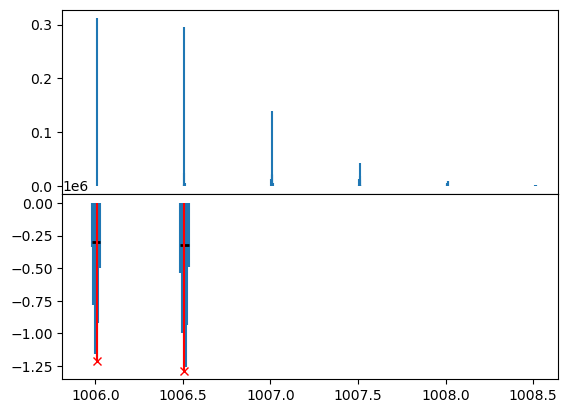

,apex_mzidx,apex_mz,start_mzidx,start_mz,end_mzidx,end_mz,peak_width,peak_height,peak_intensity_sum
0,7,1006.007087,4,1005.978361,9,1006.026239,0.047878,302067.40625,4.906113e+06
1,20,1006.505206,18,1006.486040,23,1006.533955,0.047914,321781.87500,5.505740e+06


In [ ]:
from result_analysis.result_analysis import PlotIsoPatternAndScan

PlotIsoPatternAndScan(
    MS1Scans=MS1Scans,
    Maxquant_result=Maxquant_result_dict,
    scan_idx=None,
    precursor_idx=18083,
    log_intensity=False,
)

<module 'utility' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utility.py'>

Cosine distance of non zero entries in prediction: 0.00980649186033511
Intensity Explained: 0.0434
Peaks Explained: 0.4591


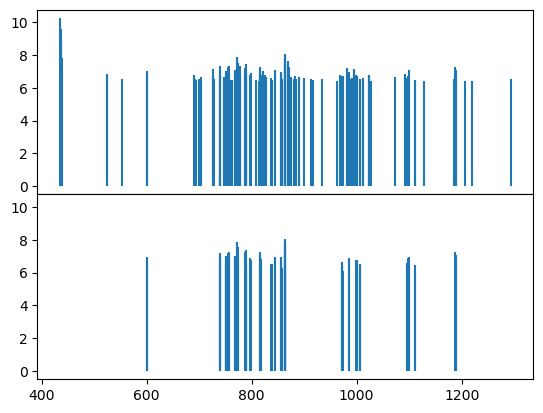

In [ ]:
from optimization.dictionary import ConstructDict
from result_analysis.result_analysis import PlotTrueAndPredict

alignment = []
scan_idx = 3830
RT_tol = 1
alpha = 10
# example: generate dictionary for candidate in one scan
OneScan = MS1Scans.iloc[scan_idx, :]
CandidatePrecursorsByRT = Maxquant_result_dict.loc[
    (
        Maxquant_result_dict["Calibrated retention time start"] - RT_tol
        <= OneScan["starttime"]
    )
    & (
        Maxquant_result_dict["Calibrated retention time finish"] + RT_tol
        >= OneScan["starttime"]
    )
]
if CandidatePrecursorsByRT.shape[0] > 0:
    (
        CandidateDict,
        CandidatePrecursorsByRT,
        alignment,
        IsotopeNotObs,
        y_true,
        peak_results,
    ) = ConstructDict(CandidatePrecursorsByRT, OneScan, method="peakRange")
    filteredPrecursorIdx = np.array(CandidateDict.columns[0:], dtype=int)
    if CandidateDict.shape[1] > 1:
        (
            activationByScan,
            lossByScan,
            scoreByScan,
            pred,
            IntensityExplained,
            peaksExplained,
        ) = utility.CalcPrecursorQuant(
            CandidateDict,
            y_true,
            filteredPrecursorIdx=filteredPrecursorIdx,
            alpha=alpha,
        )
        activation[filteredPrecursorIdx, scan_idx] = activationByScan
        # non_empty_scans.append((scan_idx, OneScan['starttime'], lossByScan, scoreByScan, CandidatePrecursorsByRT.index, filteredPrecursorIdx))
        # ScanProcessRecords[scan_idx] = {'alignment':alignment}
        PlotTrueAndPredict(
            x=CandidateDict.index, prediction=pred, true=y_true["intensity"], log=True
        )
        print("Cosine distance of non zero entries in prediction:", scoreByScan)
        print("Intensity Explained:", np.round(IntensityExplained, 4))
        print("Peaks Explained:", np.round(peaksExplained, 4))
    else:
        print(
            "Scan number, start time ",
            scan_idx,
            OneScan["starttime"],
            "does not have valid candidate.",
        )
        # empty_scans.append((scan_idx, OneScan['starttime'], 'No valid candidate after isotope pattern matching.'))

else:
    print(
        "Scan number, start time ",
        scan_idx,
        OneScan["starttime"],
        "does not have valid candidate.",
    )
    # empty_scans.append((scan_idx, OneScan['starttime'], 'No valid candidate by RT'))

In [ ]:
alignment[303]["abundance"].sum()
IsotopeNotObs[303]["abundance"].sum()

0.5232761444636144

0.4490588887347563

In [ ]:
Maxquant_result_dict.loc[11557, "IsoAbundance"].sum()

0.9723350331983707

In [ ]:
idx = np.where(filteredPrecursorIdx == 18082)
activationByScan[idx]

array([9769022.28253018])

In [ ]:
import IsoSpecPy as iso

pair = [18083, 18082]
Maxquant_result_dict.loc[
    pair, ["Modified sequence", "Charge", "Retention time", "Intensity", "m/z"]
]
iso.ParseFASTA(Maxquant_result_dict.loc[pair[0], "Modified sequence"])
iso.ParseFASTA(Maxquant_result_dict.loc[pair[1], "Modified sequence"])

,Modified sequence,Charge,Retention time,Intensity,m/z
18083,_VNQIGTLTETFEAIEM(ox)AK_,2,76.242,27290000.0,1006.00626
18082,_VNQIGTLTETFEAIEM(ox)AK_,2,75.905,NaN,1006.00626


OrderedDict([('C', 99), ('H', 162), ('N', 24), ('O', 32), ('S', 1)])

OrderedDict([('C', 99), ('H', 162), ('N', 24), ('O', 32), ('S', 1)])

In [ ]:
import IsoSpecPy as iso

Maxquant_result_dict.loc[
    [738, 10695], ["Modified sequence", "Charge", "Retention time", "Intensity", "m/z"]
]
iso.ParseFASTA(Maxquant_result_dict.loc[738, "Modified sequence"])
iso.ParseFASTA(Maxquant_result_dict.loc[10695, "Modified sequence"])

,Modified sequence,Charge,Retention time,Intensity,m/z
738,_AISVDELQK_,2,21.921,26158000.0,501.776939
10695,_LGLENVETK_,2,21.921,26158000.0,501.776939


OrderedDict([('C', 43), ('H', 73), ('N', 11), ('O', 15), ('S', 0)])

OrderedDict([('C', 43), ('H', 73), ('N', 11), ('O', 15), ('S', 0)])

In [ ]:
pair = [15879, 12747]
Maxquant_result_dict.loc[
    pair, ["Modified sequence", "Charge", "Retention time", "Intensity", "m/z"]
]
iso.ParseFASTA(Maxquant_result_dict.loc[pair[0], "Modified sequence"])
iso.ParseFASTA(Maxquant_result_dict.loc[pair[1], "Modified sequence"])

,Modified sequence,Charge,Retention time,Intensity,m/z
15879,_TDLINAVAEASSLSK_,2,70.373,20798000.0,759.904128
12747,_NIFSDPLTIEEIK_,2,70.373,20798000.0,759.906139


OrderedDict([('C', 64), ('H', 109), ('N', 17), ('O', 24), ('S', 0)])

OrderedDict([('C', 69), ('H', 109), ('N', 15), ('O', 22), ('S', 0)])

In [ ]:
pair = [3772, 3774]
Maxquant_result_dict.loc[
    pair, ["Modified sequence", "Charge", "Retention time", "Intensity", "m/z"]
]
iso.ParseFASTA(Maxquant_result_dict.loc[pair[0], "Modified sequence"])
iso.ParseFASTA(Maxquant_result_dict.loc[pair[1], "Modified sequence"])

,Modified sequence,Charge,Retention time,Intensity,m/z
3772,_EHGAVFIIGIGDALR_,3,62.458,7362600.0,523.291219
3774,_EHGAVFIIGIGDALR_,3,62.330,NaN,523.291219


OrderedDict([('C', 71), ('H', 112), ('N', 20), ('O', 19), ('S', 0)])

OrderedDict([('C', 71), ('H', 112), ('N', 20), ('O', 19), ('S', 0)])

In [ ]:
pair = [15120, 14965]
Maxquant_result_dict.loc[
    pair, ["Modified sequence", "Charge", "Retention time", "Intensity", "m/z"]
]
iso.ParseFASTA(Maxquant_result_dict.loc[pair[0], "Modified sequence"])
iso.ParseFASTA(Maxquant_result_dict.loc[pair[1], "Modified sequence"])

,Modified sequence,Charge,Retention time,Intensity,m/z
15120,_SLAEQNVILCFASGR_,2,62.377,8509700.0,832.924871
14965,_SIAAFAIHQFFQER_,2,62.060,NaN,832.930814


OrderedDict([('C', 69), ('H', 112), ('N', 20), ('O', 21), ('S', 1)])

OrderedDict([('C', 78), ('H', 111), ('N', 21), ('O', 19), ('S', 0)])

In [ ]:
for idx in [738, 10695] + [15120, 14965] + [3772, 3774] + [15879, 12747]:
    _ = postprocessing.post_processing.PlotActivation(
        MaxquantEntry=Maxquant_result_dict.iloc[idx, :],
        PrecursorTimeProfiles=[
            activation[idx, :],
            refit_activation_minima[idx, :],
            refit_activation_gaussian[idx, :],
        ],
        PrecursorTimeProfileLabels=["None", "LocalMinima", "Gaussian"],
        MS1ScansNoArrary=MS1Scans_NoArray,
        save_dir=os.path.join(report_dir, "activation", "outliers"),
    )